In [1]:
%pylab inline
import types
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter

# # set some plotting properties
fontP = FontProperties()
fontP.set_size('small')

import pandas as pd
from locale import *
setlocale(LC_NUMERIC, '')
np.set_printoptions(linewidth=800, threshold='nan', precision=5)


Populating the interactive namespace from numpy and matplotlib


In [2]:
raw = pd.read_csv('data/us_infant_mortality_2.tsv', sep='\t', thousands=',', index_col=0)

### One-at-a-time (OAT) sensitivity analysis
Each year we have the number of births and the number of child deaths for every state. The infant mortality rate is the ratio of deaths to births. Each year we can rank the states from worst (hightest rate of mortality) to best (lowest rate). With a sensitivity analysis the aim is to see how many rank positions each state moves with a change of +X and -X in the numerator. 

We'll start with Maine and make a timeseries plot of the number of rank steps changed in each year. 

Let's call the "sensitivity" the area between the +X and -X lines.

In [3]:
def OAT(raw, the_one, how_much=1, sort_cols=None, sort_asc=None):
    
    if sort_cols is not None:
        raw = raw.sort(columns=sort_cols, ascending=sort_asc)
    
    year_set = set()
    for column in raw.columns:
        year_set.add(column.split('_')[0])

    years = list(year_set)
    years.sort()
    years.insert(0, 'states')

    rates = []

    states = list(raw.index)

    for state in states:
        row = [state]
        for year in years[1:]:

            # get the birth value
            try:
                b = raw['{}_Births'.format(year)][state]
            except KeyError:
                continue

            # get death value
            if state == the_one:
                delta = how_much
            else:
                delta = 0
                
            try:
                d = atof(raw['{}_Deaths'.format(year)][state]) + delta
            except AttributeError:
                d = raw['{}_Deaths'.format(year)][state] + delta
                
            d = 0 if d < 0 else d
            
            row.append(1.0*d/b)

        rates.append(row)

    # The completed dataframe of mortality rates
    rates = pd.DataFrame.from_records(rates, columns=years, index='states')

    # Compute numerical data ranks (1 through n) among the states for each year
    ranks = rates.rank(axis=0)
    
    return (rates, ranks)

def cohens_d(means=(), stdevs=(), N_samples=()):
    """
    cohens_d giving the effect size between group 1 and group 2

    see http://en.wikipedia.org/wiki/Effect_size#Cohen.27s_d

    :param means: tuple with (M1,M2)
    :param stdevs: tuple with (V1,V2)
    :param N_samples: tuple with (N1,N2)
    :return: float, effect size
    """

    m = means
    s = stdevs
    n = N_samples
    S = sqrt(((n[0] - 1) * s[0] ** 2 + (n[1] - 1) * s[1] ** 2) / (n[0] + n[1] - 2))

    return (m[0] - m[1]) / S

In [4]:
rates, ranks = OAT(raw, 'Maine', how_much=0)
rates_plus, ranks_plus = OAT(raw, 'Maine', how_much=10)
rates_minus, ranks_minus = OAT(raw, 'Maine', how_much=-10)

In [5]:
base = ranks.loc['Maine'].to_frame(name='base')
plus = ranks_plus.loc['Maine'].to_frame(name='plus')
minus = ranks_minus.loc['Maine'].to_frame(name='minus')

maine = base.merge(plus, left_index=True, right_index=True)
maine = maine.merge(minus, left_index=True, right_index=True)

In [6]:
maine

,base,plus,minus
1995,12.0,20.0,6.0
1996,1.0,3.0,1.0
1997,2.0,4.0,1.0
1998,13.0,26.0,7.0
1999,2.0,6.0,1.0
2000,2.0,7.0,1.0
2001,18.0,24.0,7.0
2002,1.0,4.0,1.0
2003,5.0,16.0,2.0
2004,14.0,22.0,5.0


In [7]:
def area_between_curves(df):
    """df is a dataframe with 'base', 'plus', and 'minus' columns
    and year index values
    """
    running = []
    years = list(df.index)
    for year in years:
        plus = df['plus'][year]
        minus = df['minus'][year]
        running.append(plus - minus)
        
    return sum(running)

def average_change(df):
    """df is a dataframe with 'base', 'plus', and 'minus' columns
    and year index values
    """
    plus = []
    minus = []
    years = list(df.index)
    total = len(years)
    
    for year in years:
        bs = df['base'][year]
        up = df['plus'][year]
        dn = df['minus'][year]
        plus.append(up - bs)
        minus.append(bs - dn)
        
    hi = 1.0*sum(plus)/total
    low = 1.0*sum(minus)/total
        
    return (hi, low)

In [8]:
states = list(raw.index)

S = []

for state in states:
    rates_plus, ranks_plus = OAT(raw, state, how_much=10)
    rates_minus, ranks_minus = OAT(raw, state, how_much=-10)

    base = ranks.loc[state].to_frame(name='base')
    plus = ranks_plus.loc[state].to_frame(name='plus')
    minus = ranks_minus.loc[state].to_frame(name='minus')

    df = base.merge(plus, left_index=True, right_index=True)
    df = df.merge(minus, left_index=True, right_index=True)

    A = area_between_curves(df)
    
    hi, low = average_change(df)
    
    S.append([state, A, hi, low])

In [9]:
sensitivity = pd.DataFrame.from_records(S, columns=['states','sensitivity', 'high', 'low'], index='states')
sensitivity = sensitivity.sort(columns=['high', 'low', 'sensitivity'])
sensitivity

/home/jake/projects/.virtualenvs/BDN-data/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,sensitivity,high,low
states,,,
United States,1.0,0.05,0.00
Mississippi,8.0,0.15,0.25
California,7.0,0.20,0.15
Texas,17.0,0.30,0.55
Ohio,20.0,0.35,0.65
Louisiana,16.0,0.45,0.35
New York,16.0,0.45,0.35
Massachusetts,18.0,0.55,0.35
Alabama,19.0,0.60,0.35


In [10]:
mask = rates.index.isin(['Maine'])
rates_all_others = rates[~mask]

mask = rates.index.isin(['Maine'])
rates_maine_only = rates[mask]

In [11]:
def bootstrap(data, n_samples, iterations=100):
    
    means = []
    
    mn = data.min()
    mx = data.max()
    
    for i in xrange(iterations):
        samples = np.random.choice(data, size=n_samples, replace=True)
        mean = means.append(np.mean(samples))
        
    means = np.array(means)
    
    hi = np.percentile(means, 97.5)
    lo = np.percentile(means, 2.5)
    mu = np.mean(means)
    
    return (lo, mu, hi, mn, mx)
    

In [12]:
def m_histogram(data, my_bins=10, title=None, xlim=None, ylim=None):

    if not isinstance(data, types.StringType):

        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(111)

        if isinstance(data, types.DictionaryType):
            for k, v in data.iteritems():
                n, bins, patches = ax.hist(v,
                                           bins=my_bins, normed=0,
                                           alpha=0.75, label=k.title(), rwidth=1)

            # only show the legend if there are multiple arrays
            plt.legend(loc='upper right', prop=fontP, scatterpoints=1)

        else:
            n, bins, patches = ax.hist(data,
                                       bins=my_bins, normed=0,
                                       alpha=0.75, rwidth=1)

    else:
        raise TypeError('Input is either an iterable of numbers, or dict of iterables')

    bin_centers = 0.5 * np.diff(bins) + bins[:-1]

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_ylabel('Frequency')
    if title is not None:
        plt.title(title)
    plt.grid(True)
    plt.subplots_adjust(bottom=0.15)
    return n, bins, fig

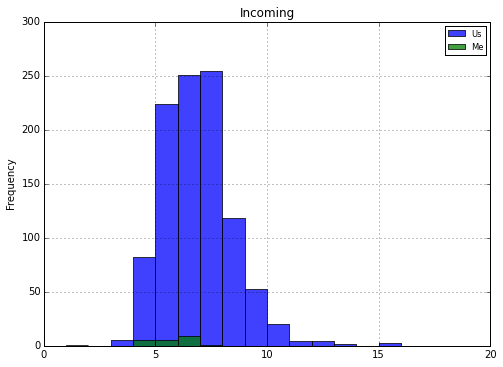

In [13]:
my_bins = np.arange(1, 20, 1)
ylim = (0, 25)
us = (1000*(rates_all_others.values)).flatten()
me = (1000*(rates_maine_only.values)).flatten()
from collections import OrderedDict
source = OrderedDict((('us', us), ('me', me)))
n, bins, h = m_histogram(source, my_bins=my_bins, title='Incoming')
h.savefig('tmp.png')

In [61]:
rates, ranks = OAT(raw, 'none', how_much=0, sort_cols=['2014_Births'], sort_asc=[False])

first_half = [str(i) for i in range(1995, 2005)]
second_half = [str(i) for i in range(2005, 2015)]
rates_first = rates[first_half]
rates_second = rates[second_half]

/home/jake/projects/.virtualenvs/BDN-data/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


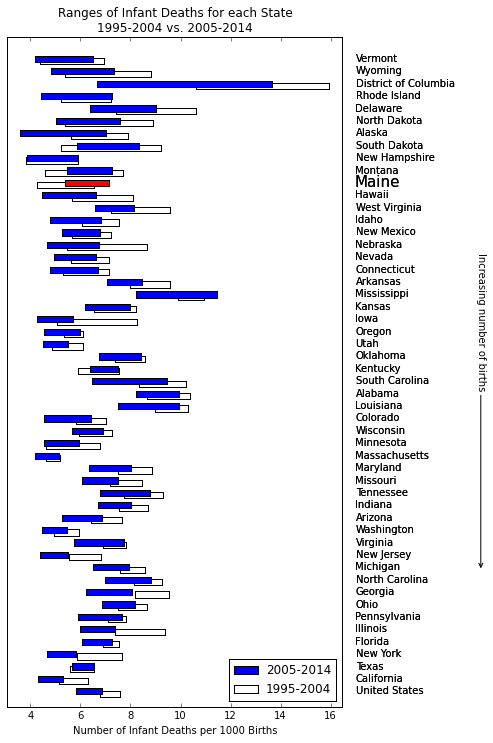

In [62]:
fig = plt.figure(num=None, figsize=(6, 12), dpi=1200, facecolor='w', edgecolor=None)

frame = plt.gca()
ax = fig.add_subplot(111)
# frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

xmin = 999
xmax = 0

for rdx, R in enumerate([rates_first, rates_second]):
    states = R.index
    for idx, state in enumerate(states):
        mask = R.index.isin([state])
        state_rates = R[mask]

        n_samples = 20
        lo, mu, hi, mn, mx = bootstrap((1000*state_rates.values).flatten(), n_samples, iterations=100)

        width = mx - mn

        xmin = mn if mn < xmin else xmin
        xmax = mx if mx > xmax else xmax

        if state == 'Maine':
            sz = 15
            if rdx > 0:
                clr = 'red'
            else:
                clr = "none"
        else:
            sz = 10
            if rdx > 0:
                clr = 'blue'
            else:
                clr = "none"
                
        if rdx > 0:
            offset = 0
        else:
            offset = 0.2

        ax.add_patch(
            matplotlib.patches.Rectangle(
                (mn, idx-offset),   # (x,y)
                width,          # width
                0.5,          # height
                facecolor=clr, 
                
            )
        )

        ax.text(17, idx+0.25, state, ha="left", va="center", size=sz)

ax.annotate('', xy=(17, 0), xycoords='axes fraction', xytext=(1, -0.1), 
            arrowprops=dict(arrowstyle="<->", color='k'))

plt.annotate('Increasing number of births',(22, 10),(22, 30),va='center',ha='center', 
               rotation=270, arrowprops=dict(arrowstyle='->'), annotation_clip=False) 

this_decade = matplotlib.patches.Rectangle((0, 2), 1, 1, facecolor='blue')
last_decade = matplotlib.patches.Rectangle((0, 1), 1, 0.25, facecolor='none')
plt.legend([this_decade, last_decade], ['2005-2014', '1995-2004'], loc='lower right')
plt.ylim(-1,53)
plt.xlim(xmin-0.5, xmax+0.5)
plt.title('Ranges of Infant Deaths for each State\n1995-2004 vs. 2005-2014')
plt.xlabel('Number of Infant Deaths per 1000 Births')
# plt.tight_layout()
plt.savefig('state_ranges.jpg')
plt.show()

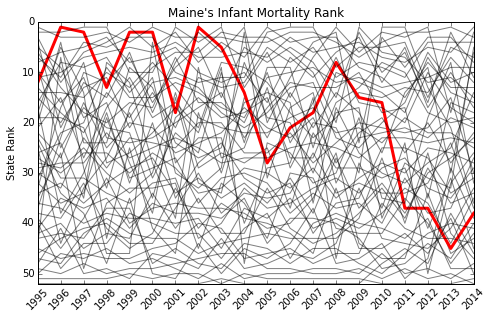

In [117]:
rates, ranks = OAT(raw, 'none', how_much=0)

fig = plt.figure(num=None, figsize=(750/96., 450/96.), dpi=96, facecolor='w', edgecolor=None)
ax = fig.add_subplot(111)

x = range(1995, 2015)

for state in ranks.index:
    
    mask = ranks.index.isin([state])
    st_ranks = ranks[mask]
    y = map(int, list(st_ranks.values.flatten()))
    
    new_england = ['Maine', 'New Hampshire', 'Massachussets', 'Vermont']
    
    if state in ['Maine']:
        ax.plot(x, y, label=state, color='r', linewidth=3)
    else:
        ax.plot(x,y, color='k', alpha=0.5)
plt.ylabel('State Rank')
plt.xlim(1995,2014)
plt.ylim(0,52)
plt.title("Maine's Infant Mortality Rank")
plt.gca().invert_yaxis()

labels = x

plt.xticks(x, labels, rotation=45)

plt.savefig('maines_rank.jpg')
plt.show()

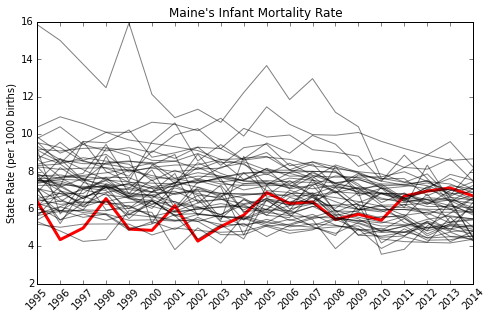

In [116]:
rates, ranks = OAT(raw, 'none', how_much=0)

fig = plt.figure(num=None, figsize=(750/96., 450/96.), dpi=96, facecolor='w', edgecolor=None)
ax = fig.add_subplot(111)

x = range(1995, 2015)

for state in rates.index:
    
    mask = rates.index.isin([state])
    st_rates = rates[mask]
    y = list((1000*st_rates.values).flatten())
    
    new_england = ['Maine', 'New Hampshire', 'Massachussets', 'Vermont']
    
    if state in ['Maine']:
        ax.plot(x, y, label=state, color='r', linewidth=3)
    else:
        ax.plot(x,y, color='k', alpha=0.5)
plt.ylabel('State Rate (per 1000 births)')
plt.xlim(1995,2014)
plt.title("Maine's Infant Mortality Rate")
labels = x

plt.xticks(x, labels, rotation=45)

plt.savefig('maines_rate.jpg')
plt.show()

In [18]:
maine_rates = rates[rates.index.isin(['Maine'])]
mr = maine_rates.values.flatten()
np.std(mr)*1000

0.86819114768608863

In [19]:
raw[['2010_Deaths', '2011_Deaths', '2010_Births', '2011_Births']]

,2010_Deaths,2011_Deaths,2010_Births,2011_Births
Alabama,524.0,488.0,60050.0,59354.0
Alaska,41.0,44.0,11471.0,11456.0
Arizona,520.0,511.0,87477.0,85543.0
Arkansas,279.0,282.0,38540.0,38715.0
California,2417.0,2403.0,510198.0,502120.0
Colorado,392.0,358.0,66355.0,65055.0
Connecticut,200.0,192.0,37708.0,37281.0
Delaware,85.0,100.0,11364.0,11257.0
District of Columbia,70.0,69.0,9165.0,9295.0
Florida,1397.0,1379.0,214590.0,213414.0


In [20]:
# how much id Maine's infant mortality rate worsen in 2011?
print 1000*(85./12704 - 70./12970)

1.29373588343


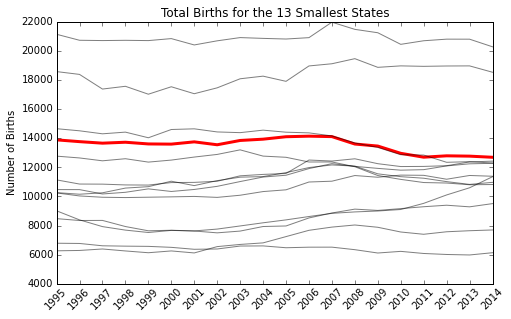

In [115]:
fig = plt.figure(num=None, figsize=(750/96., 450/96.), dpi=96, facecolor='w', edgecolor=None)
ax = fig.add_subplot(111)

x = range(1995, 2015)

births = df

import copy

births = copy.deepcopy(raw)
cols = births.columns
for col in cols:
    if 'Births' not in col:
        births.pop(col)

births
for state in births.index:
    
    mask = births.index.isin([state])
    st_rates = births[mask]
    y = map(int, list(st_rates.values.flatten()))
    
    small_states = [u'West Virginia', u'Hawaii', u'Maine', u'Montana', 
                    u'New Hampshire', u'South Dakota', u'Alaska', u'North Dakota', 
                    u'Delaware', u'Rhode Island', u'District of Columbia', u'Wyoming', 
                    u'Vermont']
    if state not in small_states:
        continue
    
    if state in ['Maine']:
        ax.plot(x, y, label=state, color='r', linewidth=3)
    else:
        ax.plot(x,y, color='k', alpha=0.5)
plt.ylabel('Number of Births')
plt.xlim(1995,2014)
plt.title("Total Births for the 13 Smallest States")
labels = x

plt.xticks(x, labels, rotation=45)

plt.savefig('maines_births.jpg')
plt.show()

732 847.0


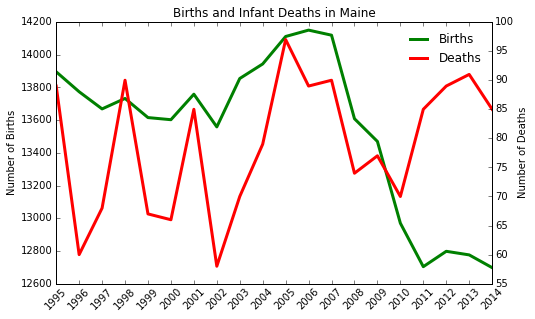

In [114]:
fig = plt.figure(num=None, figsize=(750/96., 450/96.), dpi=96, facecolor='w', edgecolor=None)
ax = fig.add_subplot(111)

x = range(1995, 2015)

births = df

import copy

births = copy.deepcopy(raw)
cols = births.columns
for col in cols:
    if 'Births' not in col:
        births.pop(col)

deaths = copy.deepcopy(raw)
cols = deaths.columns
for col in cols:
    if 'Deaths' not in col:
        deaths.pop(col)
        
maine_births = births[births.index.isin(['Maine'])]
maine_deaths = deaths[deaths.index.isin(['Maine'])]

first_half = ['{}_Deaths'.format(str(i)) for i in range(1995, 2005)]
second_half = ['{}_Deaths'.format(str(i)) for i in range(2005, 2015)]
_first = maine_deaths[first_half]
_second = maine_deaths[second_half]

print _first.values.flatten().sum(), _second.values.flatten().sum()

y = map(int, list(maine_births.values.flatten()))
lns1 = ax.plot(x, y, label='Births', color='g', linewidth=3)

ax2 = ax.twinx()
y = map(int, list(maine_deaths.values.flatten()))
lns2 = ax2.plot(x, y, label='Deaths', color='r', linewidth=3)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, frameon=False)

plt.xlim(1995,2014)
plt.title("Births and Infant Deaths in Maine")
ax.set_ylabel("Number of Births")
ax2.set_ylabel('Number of Deaths')

labels = x

plt.xticks(x, labels, rotation='vertical')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45 )
plt.savefig('maine_births_deaths.jpg')
plt.show()

## Search for anomalies with simulation
We will use two approaches to investigate the likelihood that Maine would drop to 45th place just based on random chance:
1. synthetic data from one theoretical distribution of U.S. data
  * derive a theoretical gamma distribution from the U.S. IM rate data (resulting ranks are too sensitive to small differences in rate)
  * derive population data from a distribution that matches the birth totals. 
  * 
  * pull 10 samples from the distribution for each of the 51 states+disctrict
  * calculate the rank of each sampled state in each of the 10 years
  * identify how many times we see a drop (negative delta) of > 20 in one state's rank
  * bootstrap the prior two steps 10,000 times and get a distribution of the negative deltas
2. synthetic data from theoretical distributions of each of the states
  * derive a theoretical gamma distribution based on the mean and stdst of each state (this decade only)
  * pull 10 samples from each of the 51 distributions
  * calculate the rank of each sampled state in each of the 10 years
  * identify how many times we see a drop (negative delta) of > 20 in one state's rank
  * bootstrap the prior two steps 10,000 times and get a distribution of the negative deltas
  
I would expect to see that in 1. it's rare, but not impossible to see deltas of > 20 positions. In 2. I expect that it will be much more common. Then I can redo the bar chart with simulated data in white.

In [23]:
from scipy.stats import gamma, beta
from math import sqrt

def beta_params(m,s):
    '''convert mean and std to shape params for the beta distribution'''
    a = ((1-m)/(s**2) - 1/m)*m**2
    b = a*(1/m - 1)
    return a,b

def gamma_params(m,s):
    '''convert mean and std to shape params for the gamma distribution'''
    a = (m/s)**2
    b = (s**2)/m
    return a,b

def to_unity(values):
    '''convert a list of numbers to a list with the same proportions, but sums to unity'''
    s = 1.*sum(values)
    return [i/s for i in values]


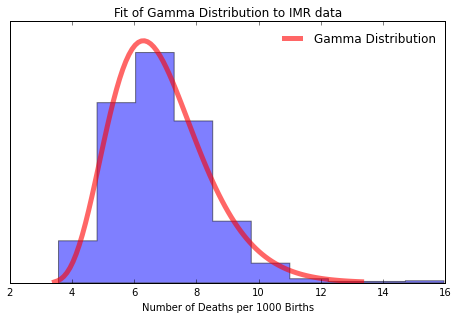

In [118]:
# derive a theoretical gamma distribution from the U.S. IM rate data (this decade only)
rates, ranks = OAT(raw, 'none', how_much=0)

first_half = [str(i) for i in range(1995, 2005)]
second_half = [str(i) for i in range(2005, 2015)]
rates_first = rates[first_half]
rates_second = rates[second_half]

data = 1000*rates.values.flatten()

fit_alpha, fit_loc, fit_beta=gamma.fit(data)

# create the theoretical distribution by fitting to the data
us_gamma = gamma.rvs(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000)

# compare the theoretical distribution to the histogram

fig = plt.figure(num=None, figsize=(750/96., 450/96.), dpi=96, facecolor='w', edgecolor=None)
ax = fig.add_subplot(111)



# frame = plt.gca()
ax.get_yaxis().set_visible(False)

start = gamma.ppf(0.0001, fit_alpha, loc=fit_loc, scale=fit_beta)
stop = gamma.ppf(0.999, fit_alpha, loc=fit_loc, scale=fit_beta)
x = np.linspace(start, stop, 100)
ax.plot(x, gamma.pdf(x, fit_alpha, loc=fit_loc, scale=fit_beta), 
        'r-', lw=5, alpha=0.6, label='Gamma Distribution')
ax.hist(data, normed=True, histtype='stepfilled', alpha=0.5)
ax.legend(loc='best', frameon=False)
plt.title('Fit of Gamma Distribution to IMR data')
plt.xlabel('Number of Deaths per 1000 Births')
plt.savefig('gamma_dist.jpg')
plt.show()


In [90]:
rates, ranks = OAT(raw, 'none', how_much=0)
rank_diffs = ranks.diff(axis=1)
rank_diffs['min_diff'] = rank_diffs.min(axis=1)
rank_diffs['max_diff'] = rank_diffs.max(axis=1)
rank_diffs['highest'] = ranks.min(axis=1)
rank_diffs['lowest'] = ranks.max(axis=1)
def hi_low_diff(row):
    hi = row.max() - row.min()
    return hi - low
rank_diffs['total_diff'] = ranks.apply(hi_low_diff, axis=1)
real_diffs = rank_diffs[['min_diff', 'max_diff', 'highest', 'lowest', 'total_diff']]
real_diffs[['total_diff']]

,total_diff
states,
Alabama,6.0
Alaska,38.0
Arizona,18.0
Arkansas,11.0
California,10.0
Colorado,19.0
Connecticut,20.0
Delaware,27.0
District of Columbia,14.0


## Strange differences
Above we have two tables, the first with simulated data, and the second derived from the original data. Each table shows the greatest rank increase (negative), the greatest rank drop, the highest and lowest overall rank, and the difference between the high and low. The total difference column from the genuine data shows that most of the states maintain their position quite well. I.e., if they are good, they stay good, and if they have a bad record, they tend to stay at the bottom (we're looking at you, D.C.). It's interesting to note that Maine and South Dakota, have the widest spread with highs to lows of 1st to 45th and 4th to 50th respectively. 

The fact that states' rankings tend to remain consistent is interesting when we look at it through the magical "lens of randomness." 

The table of simulated data shows that randomized data, that is, if states' variability in infant mortality was only due to random noise then it would be much more common for states to look like Maine and South Dakota with spreads in the 30s, 40s, and even 50s. What is strange here is that in the real data *that doesn't happen*. This begs the question, why are Maine's and South Dakota's infant mortality rates uncontrolled? 

In [157]:
from random import choice
from string import ascii_uppercase

us_rv = gamma.rvs(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000)
us_p = [gamma.cdf(i, fit_alpha, loc=fit_loc, scale=fit_beta) for i in us_rv]
us_p = to_unity(us_p)

records = []

for s in range(51):
    name = ''.join(choice(ascii_uppercase) for i in range(4))
    values = np.random.choice(us_rv, replace=True, size=10, p=us_p)
    row = [name]
    row.extend(values)
    records.append(row)
    
    
years = ['states']
years.extend(second_half)
test_1 = pd.DataFrame.from_records(records, columns=years, index='states')


In [158]:
ranks_1 = test_1.rank(axis=0)
ranks_1.diff(axis=1)

rank_diffs = ranks_1.diff(axis=1)
rank_diffs['min_diff'] = rank_diffs.min(axis=1)
rank_diffs['max_diff'] = rank_diffs.max(axis=1)
rank_diffs['highest'] = ranks_1.min(axis=1)
rank_diffs['lowest'] = ranks_1.max(axis=1)
def hi_low_diff(row):
    hi = row.max() - row.min()
    return hi - low
rank_diffs['total_diff'] = ranks_1.apply(hi_low_diff, axis=1)
simm_diffs = rank_diffs[['min_diff', 'max_diff', 'highest', 'lowest', 'total_diff']]
simm_diffs[['total_diff']]

,total_diff
states,
JCQX,48.0
HFMG,45.0
VWZE,43.0
LBBT,47.0
OSFT,41.0
QXZW,48.0
VPRL,50.0
JHCQ,46.0
GHVG,46.0


[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51]


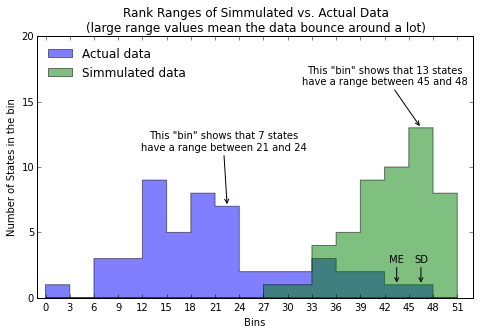

In [161]:
# show the distribution of rank ranges for the simulated random data and the actual data

# simm_diffs
mask = real_diffs.index.isin(['United States'])
real_diffs_ = real_diffs[~mask]
real_ranges = real_diffs_[['total_diff']]

simm_ranges = simm_diffs[['total_diff']]

bins = range(0, 52, 3)

fig = plt.figure(num=None, figsize=(750/96., 450/96.), dpi=96, facecolor='w', edgecolor=None)
ax = fig.add_subplot(111)

ax.hist(real_ranges.values.flatten(), normed=False, histtype='stepfilled', 
        label='Actual data', alpha=0.5, color='b', bins=bins)

ax.hist(simm_ranges.values.flatten(), normed=False, histtype='stepfilled', 
        label='Simmulated data', alpha=0.5, color='g', bins=bins)

# fit_alpha, fit_loc, fit_beta=gamma.fit(data)

# # create the theoretical distribution by fitting to the data
# us_gamma = gamma.rvs(fit_alpha, loc=fit_loc, scale=fit_beta, size=10000)

# # compare the theoretical distribution to the histogram

# start = gamma.ppf(0.001, fit_alpha, loc=fit_loc, scale=fit_beta)
# stop = gamma.ppf(0.999, fit_alpha, loc=fit_loc, scale=fit_beta)
# x = np.linspace(start, stop, 100)
# ax.plot(x, gamma.pdf(x, fit_alpha, loc=fit_loc, scale=fit_beta), 
#         'r-', lw=5, alpha=0.6, label='theoretical dist.')

plt.annotate('This "bin" shows that 7 states \nhave a range between 21 and 24',(22.5, 7),(22, 12),va='center',ha='center', 
               rotation=0, arrowprops=dict(arrowstyle='->'), annotation_clip=False) 

plt.annotate('This "bin" shows that 13 states \nhave a range between 45 and 48',(46.5, 13),(42, 17),va='center',ha='center', 
               rotation=0, arrowprops=dict(arrowstyle='->'), annotation_clip=False) 

plt.annotate('ME',(43.5, 1),(43.5, 3),va='center',ha='center', 
               rotation=0, arrowprops=dict(arrowstyle='->'), annotation_clip=False) 

plt.annotate('SD',(46.5, 1),(46.5, 3),va='center',ha='center', 
               rotation=0, arrowprops=dict(arrowstyle='->'), annotation_clip=False) 

print bins
plt.xlim(-1, 53)
plt.ylim(0, 20)
plt.title('Rank Ranges of Simmulated vs. Actual Data\n(large range values mean the data bounce around a lot)')
plt.xlabel('Bins')
plt.ylabel('Number of States in the bin')
ax.legend(loc='upper left', frameon=False)
ax.set_xticks(bins)
plt.savefig('rank_ranges.jpg')
plt.show()

784 827.0


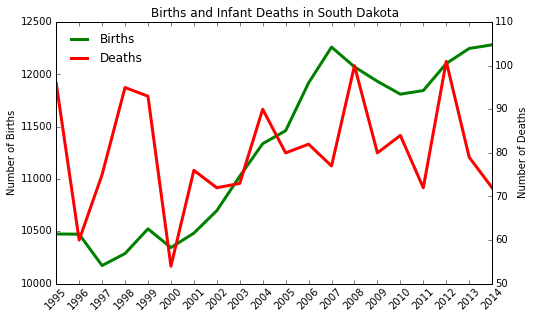

In [120]:
fig = plt.figure(num=None, figsize=(750/96., 450/96.), dpi=96, facecolor='w', edgecolor=None)
ax = fig.add_subplot(111)

x = range(1995, 2015)

births = df

import copy

births = copy.deepcopy(raw)
cols = births.columns
for col in cols:
    if 'Births' not in col:
        births.pop(col)

deaths = copy.deepcopy(raw)
cols = deaths.columns
for col in cols:
    if 'Deaths' not in col:
        deaths.pop(col)
        
maine_births = births[births.index.isin(['South Dakota'])]
maine_deaths = deaths[deaths.index.isin(['South Dakota'])]

first_half = ['{}_Deaths'.format(str(i)) for i in range(1995, 2005)]
second_half = ['{}_Deaths'.format(str(i)) for i in range(2005, 2015)]
_first = maine_deaths[first_half]
_second = maine_deaths[second_half]

print _first.values.flatten().sum(), _second.values.flatten().sum()


y = map(int, list(maine_births.values.flatten()))
lns1 = ax.plot(x, y, label='Births', color='g', linewidth=3)

ax2 = ax.twinx()
y = map(int, list(maine_deaths.values.flatten()))
lns2 = ax2.plot(x, y, label='Deaths', color='r', linewidth=3)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, frameon=False)

plt.xlim(1995,2014)
plt.title("Births and Infant Deaths in South Dakota")
ax.set_ylabel("Number of Births")
ax2.set_ylabel('Number of Deaths')

labels = x

plt.xticks(x, labels, rotation=45)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45 )
plt.savefig('south_dakota_births_deaths.jpg')
plt.show()

In [30]:
maine_deaths

,1995_Deaths,1996_Deaths,1997_Deaths,1998_Deaths,1999_Deaths,2000_Deaths,2001_Deaths,2002_Deaths,2003_Deaths,2004_Deaths,2005_Deaths,2006_Deaths,2007_Deaths,2008_Deaths,2009_Deaths,2010_Deaths,2011_Deaths,2012_Deaths,2013_Deaths,2014_Deaths
South Dakota,96,60,75,95,93,54,76,72,73,90,80.0,82,77,100.0,80.0,84.0,72.0,101.0,79,72


2012 was a bad year for South Dakota with a jump from 72 infant deaths in 2011 (23rd place) to 101 in 2012 (49th place, ahead of Alabama and Mississippi). We also see here, like Maine, that South Dakota has lost more babies in this decade than in the last. But, in contrast to Maine, they have seen an increase in numbers of births. 

What we have seen so far is that Maine far from the worst state in the union for infant mortality. However, there is an unsettling trend in decreasing births while the numbers of infant deaths has increased. Maine has also bucked the common trend for states to keeps it's position year-over-year among other states in the U.S.. It is not completely out of the question for Maine's rank changes to be due to simple randomness, but it's suspicious that Maine would be unique in both worstening IMR and uncontrolled variability.

In [31]:
ranks

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
states,,,,,,,,,,,,,,,,,,,,
Alabama,49.0,50.0,48.0,50.0,49.0,49.0,48.0,47.0,46.0,46.0,49.0,49.0,50.0,50.0,49.0,51.0,49.0,51.0,50.0,52.0
Alaska,26.0,24.0,35.0,8.0,12.0,28.0,39.0,9.0,27.0,25.0,13.0,29.0,20.0,21.0,30.0,1.0,1.0,13.0,21.0,36.0
Arizona,30.0,33.0,23.0,29.0,23.0,24.0,25.0,20.0,20.0,26.0,26.0,22.0,28.0,24.0,20.0,21.0,22.0,21.0,15.0,30.0
Arkansas,40.0,49.0,44.0,44.0,38.0,40.0,42.0,42.0,47.0,41.0,38.0,47.0,40.0,38.0,40.0,41.0,43.0,39.0,49.0,49.0
California,11.0,10.0,7.0,6.0,5.0,6.0,4.0,7.0,7.0,6.0,7.0,3.0,6.0,5.0,4.0,7.0,8.0,5.0,6.0,1.0
Colorado,13.0,18.0,22.0,14.0,19.0,12.0,11.0,13.0,18.0,21.0,18.0,13.0,12.0,23.0,25.0,20.0,16.0,6.0,12.0,10.0
Connecticut,21.0,15.0,27.0,17.0,11.0,19.0,16.0,21.0,8.0,9.0,12.0,18.0,23.0,19.0,14.0,15.0,13.0,14.0,7.0,12.0
Delaware,24.0,34.0,38.0,48.0,35.0,50.0,51.0,44.0,50.0,45.0,47.0,44.0,37.0,48.0,47.0,44.0,51.0,47.0,29.0,39.0
District of Columbia,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,51.0,52.0,52.0,52.0,52.0,52.0,52.0,48.0,45.0,48.0,38.0,46.0
